In [34]:
import os
import numpy as np
import random
from PIL import Image
from copy import deepcopy
import re
import sys
import json
import requests
from io import BytesIO
# sys.stdout = sys.__stdout__                  # restore real stdout
# from typing import List, Optional, Sequence, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.functional import relu
import torch.nn.functional as F
import torchvision.transforms as T
from torchmetrics.classification import JaccardIndex, Accuracy
from torchmetrics.functional.segmentation import mean_iou

# from torchvision import models
# from torchmetrics.classification import PrecisionRecallCurve
# from torch.amp import autocast, GradScaler
# from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Callback, Trainer, LightningModule

# from lightning.pytorch.callbacks import Callback
# from lightning.pytorch import Trainer, LightningModule
# from lightning import Trainer
# from litmodels import download_model
# from sklearn.model_selection import train_test_split

# Для более сложных аугментаций рекомендуется использовать библиотеку Albumentations
import albumentations as A
from albumentations import Compose, VerticalFlip, RandomRotate90, Affine
from albumentations.pytorch import ToTensorV2

# позволяет удобно отображать прогресс выполнения циклов
# и других длительных операций прямо в консоли или Jupyter Notebook
from tqdm import tqdm

import matplotlib.pyplot as plt
# удобный способ для работы с путями файловой системы в виде объектов
from pathlib import Path


#### VS code data load

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")
print("Path to dataset files:", path)

#### Colab data load

#### Block code

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# ускорить подбор оптимальных алгоритмов свёрток
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        # Down part
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(feature, feature, 3, padding=1),
                    nn.ReLU(),
                )
            )
            in_channels = feature
        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, stride=2))
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature*2, feature, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(feature, feature, 3, padding=1),
                    nn.ReLU(),
                )
            )
        # центральная часть сети, находящаяся между блоками «сжатия» (downsampling/encoder) и «расширения» (upsampling/decoder)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features[-1]*2, features[-1]*2, 3, padding=1),
            nn.ReLU(),
        )
        # финальный слой
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    # прямое распространение (forward pass) входных данных через всю архитектуру сети
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        return self.final_conv(x)

In [8]:
class UNetLitModule(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float = 1e-3):
        super().__init__()
        self.model = model
        self.lr    = lr
        self.loss_fn = nn.BCEWithLogitsLoss()
        # Метрики
        self.train_jaccard = JaccardIndex(task="binary", num_classes=2, threshold=0.5)
        self.val_jaccard   = JaccardIndex(task="binary", num_classes=2, threshold=0.5)
        self.train_acc     = Accuracy(task="binary")
        self.val_acc       = Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage: str):
        imgs, masks = batch
        logits      = self(imgs)
        loss        = self.loss_fn(logits, masks)
        preds       = (torch.sigmoid(logits) > 0.5).long()
        # Выбираем метрики по стадии
        if stage == "train":
            jacc = self.train_jaccard(preds, masks.long())
            acc  = self.train_acc(preds, masks.long())
        else:
            jacc = self.val_jaccard(preds, masks.long())
            acc  = self.val_acc(preds, masks.long())

        # Логируем
        self.log(f"{stage}_loss", loss,    on_epoch=True, prog_bar=True)
        self.log(f"{stage}_jacc", jacc,    on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc",  acc,     on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_train_epoch_end(self):
        self.train_jaccard.reset()
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.val_jaccard.reset()
        self.val_acc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

#### Предобработка данных и обучение

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, pairs, image_dir, mask_dir, transform=None):
        self.pairs      = pairs
        self.image_dir  = image_dir
        self.mask_dir   = mask_dir
        self.transform  = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]
        img_path  = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir,  mask_name)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask  = np.array(Image.open(mask_path).convert("L")) // 255

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]

        image = T.ToTensor()(image)
        mask  = torch.from_numpy(mask).unsqueeze(0).float()
        return image, mask

In [10]:
class MetricsHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_history = []
        self.val_history   = []

    def on_train_epoch_end(self, trainer: Trainer, pl_module):
        metrics = deepcopy(trainer.callback_metrics)
        # callback_metrics после train_epoch_end содержит train_loss и train_jacc и train_acc
        self.train_history.append({
            "epoch":      trainer.current_epoch,
            "train_loss": metrics.get("train_loss").item(),
            "train_jacc": metrics.get("train_jacc").item(),
            "train_acc":  metrics.get("train_acc").item(),
        })

    def on_validation_epoch_end(self, trainer: Trainer, pl_module):
        metrics = deepcopy(trainer.callback_metrics)
        # callback_metrics после validation содержит val_loss, val_jacc и val_acc
        self.val_history.append({
            "epoch":     trainer.current_epoch,
            "val_loss":  metrics.get("val_loss").item(),
            "val_jacc":  metrics.get("val_jacc").item(),
            "val_acc":   metrics.get("val_acc").item(),
        })

#### Images pathes

In [11]:
# пути Colab
# image_dir = '/content/Forest Segmented/Forest Segmented/images'
# mask_dir  = '/content/Forest Segmented/Forest Segmented/masks'

# пути VScode
image_dir=os.path.expanduser('~/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/images')
mask_dir=os.path.expanduser('~/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/masks')


#### Training

In [ ]:
# 1. Собираем полный список пар (изображение, маска)
all_images = sorted(os.listdir(image_dir))
all_masks  = sorted(os.listdir(mask_dir))
pairs = list(zip(all_images, all_masks))

# 2. Перемешиваем и делим на train/valid
random.seed(42)
random.shuffle(pairs)
split_idx = int(len(pairs) * 0.8)  # 80% train, 20% valid
train_pairs = pairs[:split_idx]
valid_pairs = pairs[split_idx:]

# 4. Создаем трансформации для train и valid
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
])
valid_transform = A.Compose([
    A.Resize(256, 256),
])

# 5. Инициализируем датасеты и загрузчики
train_ds = SegmentationDataset(train_pairs, image_dir, mask_dir, transform=train_transform)
valid_ds = SegmentationDataset(valid_pairs, image_dir, mask_dir, transform=valid_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, num_workers=4)

# 6. Передаем train_loader и valid_loader в Trainer
unet_model  = UNet(in_channels=3, out_channels=1)
lit_module  = UNetLitModule(unet_model, lr=1e-3)

# colab
# dirpath="/content/checkpoints"

# VScode
dirpath="./checkpoints"

checkpoint_callback = ModelCheckpoint(
    dirpath=dirpath,
    filename="epoch_{epoch:03d}",
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    verbose=True,
)

metrics_cb = MetricsHistoryCallback()

trainer = Trainer(
    max_epochs=2,
    accelerator="auto",
    devices=1,
    log_every_n_steps=10,
    callbacks=[metrics_cb, checkpoint_callback],
)
trainer.fit(lit_module, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pampa89d/miniforge3/envs/deep/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/pampa89d/Repo/projects/cv_project/notebooks/unet/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | UNet               | 31.0 M | train
1 | loss_fn       | BCEWithLogitsLoss  | 0      | train
2 | train_jaccard | BinaryJaccardIndex | 0      | train
3 | val_jaccard   | BinaryJaccardIndex | 0      | train
4 | train_acc     | BinaryAccuracy     | 0      | train
5 | val_acc       | BinaryAccuracy     | 0      | train
-------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 511: 'val_loss' reached 0.56564 (best 0.56564), saving model to '/home/pampa89d/Repo/projects/cv_project/notebooks/unet/checkpoints/epoch_epoch=000-v1.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1022: 'val_loss' reached 0.54551 (best 0.54551), saving model to '/home/pampa89d/Repo/projects/cv_project/notebooks/unet/checkpoints/epoch_epoch=001.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
metrics_1 = trainer.callback_metrics
metrics_1

{'train/loss': tensor(0.5782),
 'train/loss_step': tensor(0.5139),
 'train/iou': tensor(0.6306),
 'train/iou_step': tensor(0.7017),
 'val/loss': tensor(0.5673),
 'val/iou': tensor(0.6467),
 'train/loss_epoch': tensor(0.5782),
 'train/iou_epoch': tensor(0.6306)}

In [ ]:
metrics = trainer.callback_metrics
metrics

{'train_jaccard': tensor(0.7923),
 'train_loss': tensor(0.4675),
 'val_jaccard': tensor(0.6327),
 'val_loss': tensor(0.5772)}

#### Load checkpoint

In [12]:
# путь к файлу/модулю с классами, если файл не в основной директории то например folder.model_lib
from model_lib import UNet, UNetLitModule

In [32]:
# путь к чекпойнту
ckpt_path = "https://drive.google.com/file/d/1eHV0wfaMfA-U4Jdftlk2oevB5JWUNasd/view?usp=drive_link"

In [14]:
# воссоздаём архитектуру (должна совпадать с той, что использовалась при обучении)
base_model = UNet(in_channels=3, out_channels=1)  # 1 класс: лес/фон[1]

In [15]:
# восстанавливаем веса
lit_model: LightningModule = UNetLitModule.load_from_checkpoint(
    ckpt_path, 
    model=base_model,       # передаём базовую сеть
    lr=1e-3                 # остальные гиперпараметры
)

lit_model.eval()
lit_model.freeze()          # фиксируем параметры для чистого инференса
lit_model.to(DEVICE)

UNetLitModule(
  (model): UNet(
    (downs): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=

#### Inference

In [16]:
'''
Подготовка данных для инференса.
Приведена вспомогательная функция, 
повторяющая пайплайн предварительной обработки, использовавшийся на этапе обучения.
'''

# та же резкость 256×256, без аугментаций
inference_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

def preprocess_image(path: str) -> torch.Tensor:
    img = np.array(Image.open(path).convert("RGB"))
    tensor = inference_tf(image=img)["image"].unsqueeze(0)  # BCHW
    return tensor

In [17]:
# Инференс и получение масок
@torch.no_grad()
def predict_mask(model: LightningModule, img_tensor: torch.Tensor) -> torch.Tensor:
    img_tensor = img_tensor.to(DEVICE)
    logits = model(img_tensor)               # B×1×H×W
    probs  = torch.sigmoid(logits)           # [0;1]
    mask   = (probs > 0.5).float()           # бинаризация
    mask   = mask.cpu().squeeze(0).squeeze(0) # 1×H×W → H×W
    return mask.numpy()                     

In [18]:
# Наложение истинной и предсказанной маски
'''
фон: прозрачный;
TP (верно предсказанный лес) — зелёный;
FN (пропущенный лес) — красный;
FP (ложное срабатывание) — жёлтый.
'''
def overlay_masks(img_path: str, true_mask_path: str):
    # загрузка
    pred_mask = predict_mask(lit_model, preprocess_image(img_path))            # H×W
    true_mask = (np.array(Image.open(true_mask_path).convert("L")) // 255).astype(float) # H×W   
    
    # расчёт TP/FN/FP
    tp = pred_mask * true_mask
    fn = (1 - pred_mask) * true_mask
    fp = pred_mask * (1 - true_mask)
    
    # исходное изображение для фона
    base_img = np.array(Image.open(img_path).convert("RGB").resize((256, 256))) / 255.0
    
    # каналы наложения RGBA
    overlay = np.zeros((*tp.shape, 4))
    overlay[..., 1] = tp        # зелёный канал
    overlay[..., 0] = fn        # красный канал
    overlay[..., :3] += fp[..., None] * [1,1,0]  # жёлтый FP
    overlay[..., 3]  = 0.4 * (tp+fn+fp)          # альфа-канал
    
    # визуализация
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=100)
    ax[0].imshow(base_img)
    ax[1].imshow(base_img)
    ax[1].imshow(overlay)
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title("Basic image")
    ax[1].set_title("True vs Predicted mask overlay")
    plt.show()

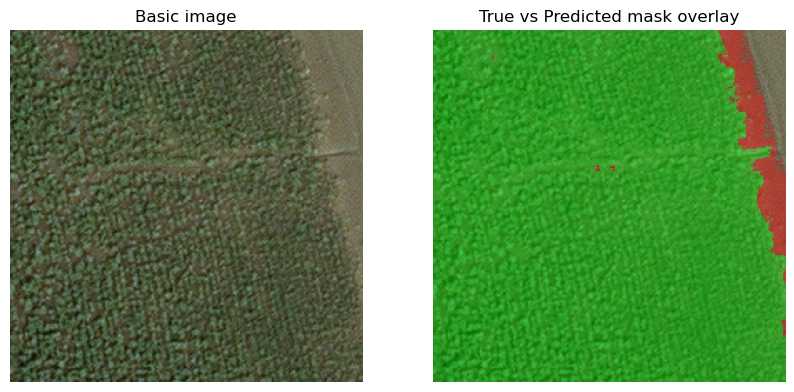

In [19]:
img_path=os.path.expanduser('~/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/images/855_sat_01.jpg')
true_mask_path=os.path.expanduser('~/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/masks/855_mask_01.jpg')

overlay_masks(
    img_path=img_path,
    true_mask_path=true_mask_path
)

#### Predict results

In [25]:
def get_val_transform(size: int = 256):
    return A.Compose([
        A.Resize(size, size),
        A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ])

@torch.no_grad()
def overlay_prediction_only(img_path: str,
                            model: torch.nn.Module,
                            transform=None,
                            threshold: float = 0.5,
                            alpha: float = 0.4,
                            figsize: tuple = (6, 6),
                            dpi: int = 100):
    """
    Отображает одно тестовое изображение с наложенной предсказанной моделью маской,
    когда истинная маска отсутствует.
    
    Параметры:
    - img_path: путь к RGB-изображению
    - model: LitModule или nn.Module, возвращающий логиты B×1×H×W
    - transform: функция/Albumentations.Transform, приводящая изображение к тензору C×H×W
    - threshold: порог бинаризации вероятностей
    - alpha: прозрачность слоя предсказанной маски
    - figsize: размер фигуры в дюймах
    - dpi: разрешение фигуры
    """
    # Загрузка и подготовка изображения
    img = np.array(Image.open(img_path).convert("RGB"))
    H, W = img.shape[:2]
    inp = transform(image=img)["image"].unsqueeze(0).to(next(model.parameters()).device)  # B×C×h×w
    
    # Предсказание вероятностей и бинаризация
    logits = model(inp)                       # B×1×h×w
    probs  = torch.sigmoid(logits)[0, 0].cpu().numpy()  # h×w
    pred_mask = (probs > threshold).astype(float)      # h×w

    # Усреднённая уверенность по всем пикселям
    avg_conf = probs.mean() * 100  # в процентах
    
    # Приведение маски к размеру оригинала, если трансформ масштабировал
    pred_mask_img = Image.fromarray((pred_mask * 255).astype(np.uint8)).resize((W, H), resample=Image.NEAREST)
    pred_mask = np.array(pred_mask_img) / 255.0        # H×W
    
    # Подготовка фонового изображения
    base_img = img / 255.0
    
    # Создание RGBA-слоя для предсказанной маски (зелёный)
    overlay = np.zeros((H, W, 4))
    overlay[..., 2] = pred_mask     # зелёный канал
    overlay[..., 3] = alpha * pred_mask  # альфа-канал
    
    # Визуализация
    fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    ax[0].imshow(base_img)
    ax[1].imshow(base_img)
    ax[1].imshow(overlay)
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title("Basic image")
    ax[1].set_title(f"Image with Predicted (avg conf {avg_conf:.1f}%)")
    plt.show()


In [ ]:
# для 1 фото
img_path=os.path.expanduser('~/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest_Segmented/images/855_sat_01.jpg')

overlay_prediction_only(img_path=img_path, 
                        model=lit_model,
                        transform=get_val_transform(),
                        threshold=0.7,
                        alpha=0.5,
                        figsize=(10, 10),
                        dpi=150)

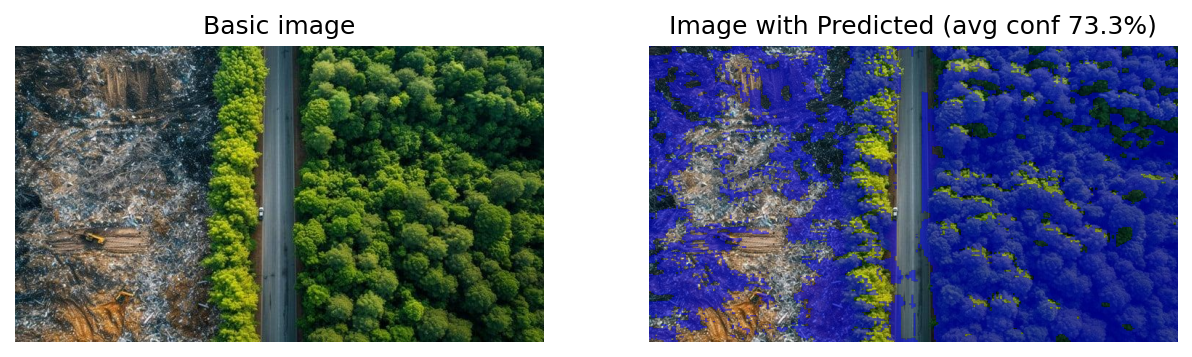

In [35]:
path_ = 'https://images.stockcake.com/public/d/2/0/d20c6b7a-67b8-450d-a133-3041d913036c_large/deforestation-versus-nature-stockcake.jpg'

# проверка сслыка, файл или диерктория
if os.path.isdir(path_):
    fld_path = os.walk(os.path.expanduser(path_))
    for folder, subfolders, files in fld_path:
        for name in files:
            if name.endswith('.jpg'):
                img_path = os.path.join(folder, name)
                overlay_prediction_only(img_path=img_path, 
                                        model=lit_model,
                                        transform=get_val_transform(),
                                        threshold=0.4,
                                        alpha=0.5,
                                        figsize=(10, 10),
                                        dpi=150)
elif path_.startswith('http://') or path_.startswith('https://'):
    response = requests.get(path_)
    img = Image.open(BytesIO(response.content))
    img.save('tmp.jpg')  # сохраняем во временный файл
    img_path = 'tmp.jpg'
    overlay_prediction_only(img_path=img_path, 
                        model=lit_model,
                        transform=get_val_transform(),
                        threshold=0.7,
                        alpha=0.5,
                        figsize=(10, 10),
                        dpi=150)
else:
    img_path=os.path.expanduser(path_)
    overlay_prediction_only(img_path=img_path, 
                            model=lit_model,
                            transform=get_val_transform(),
                            threshold=0.7,
                            alpha=0.5,
                            figsize=(10, 10),
                            dpi=150)